## **Import**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib

# Afficher les versions des bibliothèques utilisées
print("Versions des bibliothèques utilisées :")
print(f"Pandas : {pd.__version__}")
print(f"NumPy : {np.__version__}")
print(f"Scikit-learn : {sklearn.__version__}")
print(f"Matplotlib : {matplotlib.__version__}")
print(f"Seaborn : {sns.__version__}")


Versions des bibliothèques utilisées :
Pandas : 2.2.2
NumPy : 1.26.4
Scikit-learn : 1.4.2
Matplotlib : 3.8.4
Seaborn : 0.13.2


In [12]:
# Chargement des données
rfm_time = pd.read_csv('rfm-time.csv', parse_dates=['order_purchase_timestamp'])

## **Contrat de maintenance**

In [15]:
rfm_time.dtypes

Recency                                       float64
Frequency                                     float64
Monetary                                      float64
R_Score                                         int64
F_Score                                         int64
M_Score                                         int64
order_purchase_timestamp               datetime64[ns]
customer_id                                    object
customer_zip_code_prefix                      float64
review_score                                  float64
Weighted_Review_Score                         float64
Loyalty_Index                                 float64
Payment_credit_card                              bool
Payment_debit_card                               bool
Payment_voucher                                  bool
Category_Electronics and Technology              bool
Category_Fashion and Accessories                 bool
Category_Food and Beverages                      bool
Category_Health and Beauty  

In [17]:
# Fonction pour simuler un fichier client Fi à une date donnée
def generate_customer_file(data, date):
    """
    Retourne les commandes passées avant ou à la date donnée.

    Args:
        data (pd.DataFrame): DataFrame des fichiers clients.
        date (str ou pd.Timestamp): Date limite de filtrage.

    Returns:
        pd.DataFrame: Commandes filtrées.
    """
    return data[data['order_purchase_timestamp'] <= date]

In [19]:
# Fonction pour calculer l'ARI tous les x jours
def simulate_ari_evolution(rfm_time, start_date, end_date, step_days, n_clusters):
    """
    Simule l'évolution de l'ARI sur une période donnée en appliquant le clustering.

    Args:
        rfm_time (pd.DataFrame): Données RFM sur la période.
        start_date (str ou pd.Timestamp): Date de début de la simulation.
        end_date (str ou pd.Timestamp): Date de fin de la simulation.
        step_days (int): Pas en jours entre chaque simulation.
        n_clusters (int): Nombre de clusters pour le K-Means.

    Returns:
        pd.DataFrame: Historique de l'ARI par date.
    """
    dates = pd.date_range(start=start_date, end=end_date, freq=f"{step_days}D")
    ari_scores = []
    
    # Entraîner le premier modèle M0
    initial_data = generate_customer_file(rfm_time, dates[0])
    if initial_data.empty:
        raise ValueError("Aucune donnée disponible pour la date de début.")
    
    scaler = StandardScaler()
    initial_features = scaler.fit_transform(initial_data[['Recency', 'Frequency', 'Monetary','R_Score', 'F_Score', 'M_Score',
                                                          'customer_zip_code_prefix', 'review_score', 'Weighted_Review_Score', 'Loyalty_Index']])
    model_m0 = KMeans(n_clusters=n_clusters, random_state=42)
    c0 = model_m0.fit_predict(initial_features)

    # Boucle sur les dates pour calculer l'ARI
    for current_date in dates[1:]:
        # Générer les données jusqu'à la date courante
        current_data = generate_customer_file(rfm_time, current_date)
        if current_data.empty:
            ari_scores.append((current_date, None))  # Ajouter un point avec ARI = None
            continue

        # Standardiser les nouvelles données avec le scaler de M0
        current_features_scaled = scaler.transform(current_data[['Recency', 'Frequency', 'Monetary','R_Score', 'F_Score', 'M_Score',
                                                          'customer_zip_code_prefix', 'review_score', 'Weighted_Review_Score', 'Loyalty_Index']])

        # Prédire les clusters avec le modèle initial M0
        c1_init = model_m0.predict(current_features_scaled)

        # Entraîner un nouveau modèle M1
        scaler_new = StandardScaler()
        current_features_new = scaler_new.fit_transform(current_data[['Recency', 'Frequency', 'Monetary','R_Score', 'F_Score', 'M_Score',
                                                          'customer_zip_code_prefix', 'review_score', 'Weighted_Review_Score', 'Loyalty_Index']])
        model_m1 = KMeans(n_clusters=n_clusters, random_state=42)
        c1_new = model_m1.fit_predict(current_features_new)

        # Calculer l'ARI entre les clusters prédits et les nouveaux clusters
        score = ari(c1_init, c1_new)
        ari_scores.append((current_date, score))

    # Transformer les résultats en DataFrame
    ari_df = pd.DataFrame(ari_scores, columns=['Date', 'ARI'])
    return ari_df

In [21]:
# Paramètres de la simulation
start_date = '2017-12-31'
end_date = '2018-08-31'
step_days = 10
n_clusters = 4

In [23]:
# Simuler l'évolution de l'ARI
ari_results = simulate_ari_evolution(rfm_time, start_date, end_date, step_days, n_clusters)

# Remplacer les valeurs None par NaN pour éviter les erreurs dans la visualisation
ari_results['ARI'] = ari_results['ARI'].fillna(np.nan)

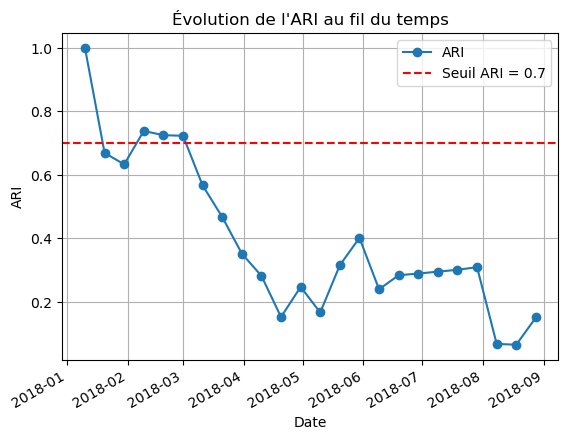

In [24]:
# Visualisation de l'évolution de l'ARI
plt.plot(ari_results['Date'], ari_results['ARI'], marker='o', label='ARI')
plt.axhline(y=0.7, color='r', linestyle='--', label='Seuil ARI = 0.7')
plt.title("Évolution de l'ARI au fil du temps")
plt.xlabel("Date")
plt.ylabel("ARI")
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()  
plt.show()

Cette ARI montre qu'avec un seuil à 0,7, le modèle devra être modifié au bout d'environ 60 jours.

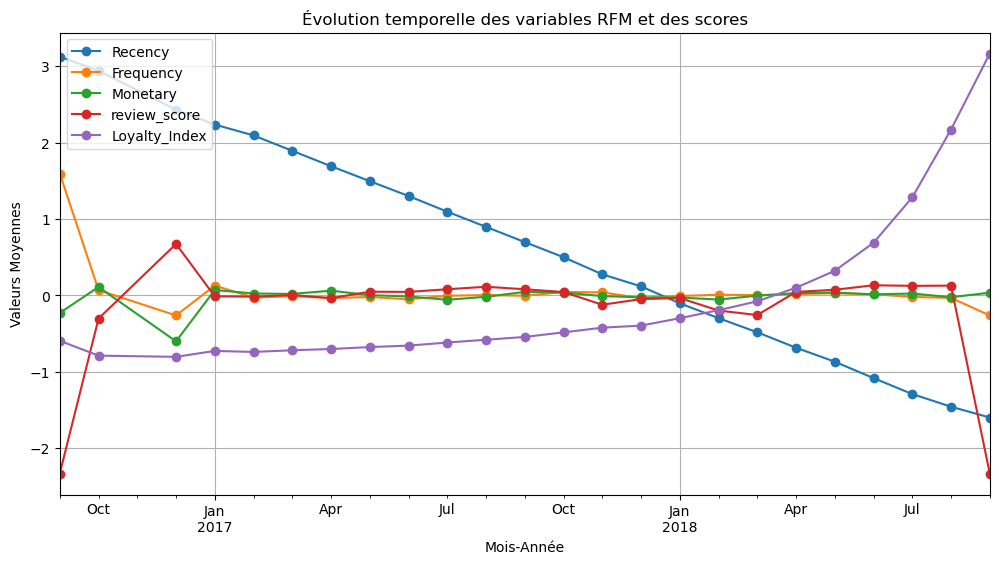

In [108]:
# Créer une colonne "mois-année"
rfm_time['month_year'] = rfm_time['order_purchase_timestamp'].dt.to_period('M')

# Agréger les données par mois pour calculer la moyenne des variables numériques
agg_data = rfm_time.groupby('month_year')[['Recency', 'Frequency', 'Monetary', 'review_score', 'Loyalty_Index']].mean()

# Tracer l'évolution de chaque feature
plt.figure(figsize=(12, 6))
agg_data.plot(ax=plt.gca(), marker='o')
plt.title("Évolution temporelle des variables RFM et des scores")
plt.xlabel("Mois-Année")
plt.ylabel("Valeurs Moyennes")
plt.legend(loc='upper left')
plt.grid()
plt.show()


Recency (bleu) : On observe une forte diminution au fil du temps. Cela signifie que les clients récents (avec une valeur de Recency faible) deviennent plus fréquents dans les périodes ultérieures. Cela peut indiquer une amélioration de la fidélisation ou une campagne réussie pour attirer des clients actifs.
Frequency (orange) : La courbe est stable après une forte diminution initiale. Cela peut signifier qu'après une période d'achat intense (pic initial), les clients ont un comportement plus stable.
Monetary (vert) : Relativement stable, indiquant que le montant dépensé par les clients n’a pas de variations significatives au fil du temps.
Review_score (rouge) : La courbe montre des fluctuations, ce qui pourrait indiquer des périodes où les avis clients sont plus négatifs ou plus positifs. Une chute soudaine peut alerter sur des problèmes de service ou de produit.
Loyalty_Index (violet) : Une forte augmentation au fil du temps indique une fidélité croissante des clients. Cela peut refléter des efforts pour maintenir l’engagement des clients ou améliorer la satisfaction.

Loyalty_Index et Recency : On remarque une corrélation inverse. Plus le Loyalty_Index augmente, plus la Recency diminue, ce qui est logique : des clients plus fidèles achètent plus souvent.
Review_score et Frequency : Si les scores d’avis fluctuent en même temps que la fréquence d’achat, cela peut indiquer une sensibilité des clients à la qualité du service.

La chute soudaine du review_score ou du Frequency sur certaines périodes (fin de graphique) peut nécessiter une analyse plus détaillée pour identifier les causes (problèmes saisonniers, changements dans le produit ou le service).

En résumé, ce graphique montre des tendances claires :

    Fidélité en amélioration (augmentation du Loyalty_Index et diminution de la Recency).
    Stabilité des dépenses (Monetary) et de la fréquence (Frequency).
    Avis fluctuants qui pourraient nécessiter une enquête.